# Airbnb New York City Price Prediction Models
***
#### Team members: Jiwoong Kim, Kai-Ping (Rory) Wang, Phuong Ngo

For our final project, we decided to look into the relationship between Airbnb listing prices and their determinants. We were specifically interested in NYC for its diversity in property types and neighborhoods. There are several cool projects previously done by others, including <a href='https://towardsdatascience.com/predicting-airbnb-prices-with-machine-learning-and-deep-learning-f46d44afb8a6'>this one</a> by Laura Lewis with the data from London, but our goal is to add a little touch of NLP analysis by looking into textual features such as property description and customer reviews as possible predictors.

***
## The Dataset
The dataset for this project was obtained from <a link='http://insideairbnb.com'>insideairbnb.com</a>. We used the latest dataset collected for the New York city, dated Oct 5, 2020.

***
## Data Cleaning / Preprocessing
(Disclaimer: This section has been largely adapted from Laura Lewis' work linked above, but customized to account for the differences in the NYC dataset.)

### Importing the libraries and the data

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import xgboost as xgb
from xgboost import plot_importance
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from datetime import datetime
import time
import warnings

seed(123)
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
raw_df = pd.read_csv('data/insideairbnb-nyc-10-05-20/listings.csv', encoding='utf-8')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns))
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 44666 Airbnb listings


id                        listing_url       scrape_id last_scraped  \
0  2595  https://www.airbnb.com/rooms/2595  20201005145859   2020-10-07   
1  3831  https://www.airbnb.com/rooms/3831  20201005145859   2020-10-09   
2  5121  https://www.airbnb.com/rooms/5121  20201005145859   2020-10-09   

                                                name  \
0                              Skylit Midtown Castle   
1  Whole flr w/private bdrm, bath & kitchen(pls r...   
2                                    BlissArtsSpace!   

                                         description  \
0  Beautiful, spacious skylit studio in the heart...   
1  Enjoy 500 s.f. top floor in 1899 brownstone, w...   
2  <b>The space</b><br />HELLO EVERYONE AND THANK...   

                               neighborhood_overview  \
0  Centrally located in the heart of Manhattan ju...   
1  Just the right mix of urban center and local n...   
2                                                NaN   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/f0813a11-40b2...     2845   
1  https://a0.muscache.com/pictures/e49999c2-9fd5...     4869   
2  https://a0.muscache.com/pictures/2090980c-b68e...     7356   

                                 host_url    host_name  host_since  \
0  https://www.airbnb.com/users/show/2845     Jennifer  2008-09-09   
1  https://www.airbnb.com/users/show/4869  LisaRoxanne  2008-12-07   
2  https://www.airbnb.com/users/show/7356        Garon  2009-02-03   

                       host_location  \
0  New York, New York, United States   
1  New York, New York, United States   
2  New York, New York, United States   

                                          host_about host_response_time  \
0  A New Yorker since 2000! My passion is creatin...       within a day   
1  Laid-back Native New Yorker (formerly bi-coast...     within an hour   
2   I am an artist(painter, filmmaker) and curato...                NaN   

  host_response_rate host_acceptance_rate host_is_superhost  \
0                70%                  25%                 f   
1                98%                  96%                 f   
2                NaN                 100%                 f   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/im/pictures/user/50fc5...   
1  https://a0.muscache.com/im/users/4869/profile_...   
2  https://a0.muscache.com/im/pictures/user/72a61...   

                                    host_picture_url  host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/50fc5...             Midtown   
1  https://a0.muscache.com/im/users/4869/profile_...        Clinton Hill   
2  https://a0.muscache.com/im/pictures/user/72a61...  Bedford-Stuyvesant   

   host_listings_count  host_total_listings_count  \
0                  6.0                        6.0   
1                  1.0                        1.0   
2                  1.0                        1.0   

                                  host_verifications host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'offline_governm...                    t   
1  ['email', 'phone', 'reviews', 'offline_governm...                    t   
2  ['email', 'phone', 'facebook', 'reviews', 'off...                    t   

  host_identity_verified                      neighbourhood  \
0                      t            New York, United States   
1                      t  Brooklyn, New York, United States   
2                      t                                NaN   

  neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  \
0                Midtown                    Manhattan  40.75362  -73.98377   
1           Clinton Hill                     Brooklyn  40.68514  -73.95976   
2     Bedford-Stuyvesant                     Brooklyn  40.68688  -73.95596   

               property_type        room_type  accommodates  bathrooms  \
0           Entire apartment  Entire home/apt             2        NaN   
1     

### Dropping non-predictive columns

Drop non-predictive, textual columns:

In [3]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview',
                'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about',
                'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications',
                'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

Checking if there are any columns that do not have values for the majority of the rows:

In [4]:
df.isna().sum()

id                                                  0
host_since                                         17
host_response_time                              23079
host_response_rate                              23079
host_acceptance_rate                            16865
host_is_superhost                                  17
host_listings_count                                17
host_total_listings_count                          17
host_has_profile_pic                               17
host_identity_verified                             17
neighbourhood                                   16458
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                   

Drop the following three columns because 100% of the rows have null values: `bathrooms`, `calendar_updated`, `license`:

In [5]:
df.drop(['bathrooms', 'calendar_updated', 'license'], axis=1, inplace=True)
# use 'id' as index
df.set_index('id', inplace=True)

`host_listings_count` and `host_total_listings_count`:
- The values for these two the same for all but 17 rows.
- In those 17 rows, the values for these two columns are both NaN.
- Therefore one of these columns can be dropped.

In [6]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.drop(['host_total_listings_count'], axis=1, inplace=True)

17


`calculated_host_listings_count`, `calculated_host_listings_count_entire_homes`, `calculated_host_listings_count_private_rooms`, `calculated_host_listings_count_shared_rooms` columns:
- These 4 columns are highly correlated with host_listings_count and can be dropped.

In [7]:
df.drop(['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
         'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'],
        axis=1, inplace=True)

Columns related property location:
- `neighbourhood_cleansed` and `neighbourhood_group_cleansed` will be kept.
- `neighbourhood` can be dropped.
- latitude and longitude will be also dropped.

In [8]:
df.drop(['neighbourhood', 'latitude', 'longitude'], axis=1, inplace=True)

Columns related to min/max nights:
- There are multiple columns related min/max nights that account for seasonality,
- Two default columns will be used: `minimum_nights` and `maximum_nights`
- The other columns will be dropped: `minimum_minimum_nights`, `maximum_minimum_nights`, `minimum_maximum_nights`, `maximum_maximum_nights`, `minimum_nights_avg_ntm`, `maximum_nights_avg_ntm`

In [9]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
         'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

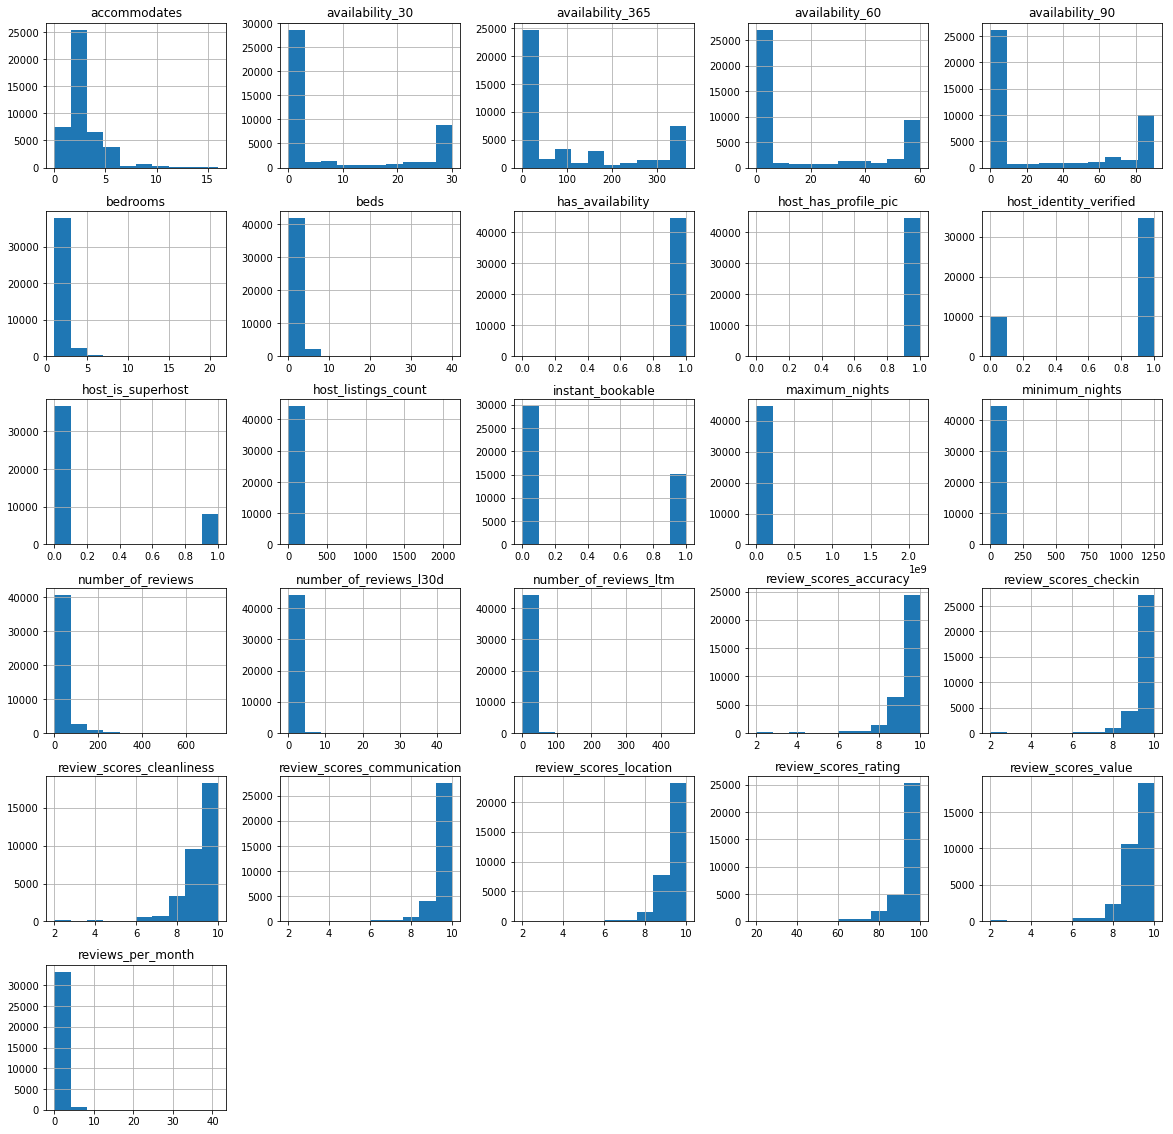

In [10]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [11]:
df.drop(['has_availability', 'host_has_profile_pic'], axis=1, inplace=True)

### Cleaning/preprocessing individual columns

#### host_since

This is a datetime column, and will be converted into the number of days that a host has been on the platform, measured from the date that the data was scraped (Oct 5 2020).

In [12]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2020, 10, 5) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1876.0
Median days as host: 1911.0


#### host_response_time

About 50% of rows don't have a value for `host_response_time`. They will be retained as its own category, `unknown`.

In [13]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

Null values: 23079
Proportion: 51.7%


In [14]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

unknown               0.516702
within an hour        0.244213
within a few hours    0.112479
within a day          0.082277
a few days or more    0.044329
Name: host_response_time, dtype: float64

#### host_response_rate

About 50% of rows don't have a value for `host_response_rate`. They will be retained as its own category, `unknown`, after grouping other values into caterogical values.

In [15]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 23079
Proportion: 51.7%


In [16]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 86.0
Median host response rate: 100.0
Proportion of 100% host response rates: 61.0%


In [17]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

unknown    23079
100%       13165
50-89%      4018
0-49%       2543
90-99%      1861
Name: host_response_rate, dtype: int64

#### host_acceptance_rate

Do the same thing for `host_acceptance_rate`.

In [18]:
print("Null values:", df.host_acceptance_rate.isna().sum())
print(f"Proportion: {round((df.host_acceptance_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 16865
Proportion: 37.8%


In [19]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_acceptance_rate = df.host_acceptance_rate.str[:-1].astype('float64')

print("Mean host acceptance rate:", round(df['host_acceptance_rate'].mean(),0))
print("Median host acceptance rate:", df['host_acceptance_rate'].median())
print(f"Proportion of 100% host acceptance rates: {round(((df.host_acceptance_rate == 100.0).sum()/df.host_acceptance_rate.count())*100,1)}%")

Mean host acceptance rate: 81.0
Median host acceptance rate: 94.0
Proportion of 100% host acceptance rates: 32.5%


In [20]:
# Bin into four categories
df.host_acceptance_rate = pd.cut(df.host_acceptance_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_acceptance_rate = df.host_acceptance_rate.astype('str')

# Replace nulls with 'unknown'
df.host_acceptance_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_acceptance_rate.value_counts()

unknown    16865
100%        9045
50-89%      7715
90-99%      6697
0-49%       4344
Name: host_acceptance_rate, dtype: int64

#### host_is_superhost

There are 17 rows lacking values for each of four different host-related features. These rows will be dropped.

In [21]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_since', 'host_is_superhost', 'host_listings_count', 'host_identity_verified'] ].isnull().sum(axis=1) == 4])

17

In [22]:
df.dropna(subset=['host_since'], inplace=True)

#### property_type

There are a large number of categories with only a few listings. Will retain the categories that have over 100 rows as they are, and others will be categorized to `Other`.

In [23]:
df.property_type.value_counts()

Entire apartment                      18575
Private room in apartment             15338
Private room in house                  2247
Private room in townhouse              1073
Entire house                           1064
Entire condominium                     1028
Entire loft                             725
Shared room in apartment                685
Entire townhouse                        636
Private room in condominium             566
Private room in loft                    412
Room in boutique hotel                  387
Room in hotel                           333
Entire serviced apartment               318
Entire guest suite                      263
Private room in guest suite             113
Shared room in house                    103
Private room in hostel                   82
Room in aparthotel                       58
Private room in resort                   52
Room in serviced apartment               48
Private room in bed and breakfast        45
Entire guesthouse               

In [24]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Entire serviced apartment': 'Entire apartment',
    'Room in boutique hotel': 'Room in hotel',
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin([
    'Entire apartment',
    'Private room in apartment',
    'Private room in house',
    'Private room in townhouse',
    'Entire house',
    'Entire condominium',
    'Entire loft',
    'Shared room in apartment',
    'Entire townhouse',
    'Private room in condominium',
    'Private room in loft',
    'Room in hotel',
    'Entire guest suite',
    'Private room in guest suite',
    'Shared room in house'
    ]), 'property_type'] = 'Other'

#### bedrooms

About 20% of data have missing value for `bedrooms`. The data shows that most of them are entire apartments so presumably they must be studio apartments with no separate bedroom. To preserve the information value (null or 0 = studio), we will convert this attribute from a numerical one to a categorical one.

In [25]:
df.bedrooms.fillna("studio", inplace=True)

df.bedrooms.replace({
    1: '1 bedroom',
    2: '2 bedrooms',
    3: '3 bedrooms',
    4: '4 bedrooms',
    5: '5 bedrooms',
    6: '6 bedrooms',
    7: '7 bedrooms',
    8: '8 bedrooms',
    9: '9 bedrooms',
    10: '10 bedrooms',
    11: '11 bedrooms',
    13: '13 bedrooms',
    14: '14 bedrooms',
    21: '21 bedrooms'
    }, inplace=True)

#### beds

There are 513 rows lacking values for `beds`. Missing values will be replaced with the median.

In [26]:
df.beds.fillna(df.beds.median(), inplace=True)

#### bathrooms_text

There are 90 rows lacking values for `bathrooms_text`. These rows will be dropped.

In [27]:
df.dropna(subset=['bathrooms_text'], inplace=True)

#### amenities

Amenities is a list of additional features in the property:

In [28]:
# Example of amenities listed
df.amenities[:1].values

array(['["Hot water", "Stove", "Extra pillows and blankets", "Smoke alarm", "Laptop-friendly workspace", "Coffee maker", "Bed linens", "Dishes and silverware", "Oven", "Wifi", "Air conditioning", "Paid parking off premises", "Baking sheet", "Fire extinguisher", "Free street parking", "Essentials", "Heating", "Kitchen", "Carbon monoxide alarm", "Cooking basics", "Refrigerator", "Hair dryer", "Hangers", "Keypad", "Bathtub", "Ethernet connection", "TV", "Iron", "Cleaning before checkout", "Long term stays allowed", "Luggage dropoff allowed"]'],
      dtype=object)

In [29]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('[', '')
amenities_list_string = amenities_list_string.replace(']', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '2 burner hot plate electric stove',
 '32\\ HDTV',
 '32\\ HDTV with Amazon Prime Video',
 '32\\ HDTV with HBO Max',
 '32\\ HDTV with Netflix',
 '32\\ TV',
 '39\\ HDTV',
 '40\\ HDTV with Chromecast',
 '40\\ HDTV with Netflix',
 '40\\ HDTV with standard cable',
 '42\\ HDTV with Netflix',
 '45\\ HDTV with Netflix',
 '46\\ HDTV with premium cable',
 '47\\ HDTV',
 '50\\ HDTV with Netflix',
 '50\\ TV with Chromecast',
 '52\\ HDTV',
 '55\\ HDTV with Netflix',
 '55\\ TV',
 '58\\ HDTV with Netflix',
 '65\\ HDTV with Netflix',
 '75\\ HDTV with Netflix',
 'Aesop',
 'Air conditioning',
 'Amazon Prime Video',
 'Americana refrigerator',
 'BBQ grill',
 'BOSE sound system with Bluetooth and aux',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Barbecue utensils',
 'Bath & Body Works body soap',
 'Bath & Body Works conditioner',
 'Bath & Body Works shampoo',
 'Bathtub',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Beko refrigerator',
 'Bluetooth sound syst

The amenities are categorized into several groups:

In [30]:
df.loc[df['amenities'].str.contains('fitness|Fitnesse|Gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('TV|HDTV|Cable|Amazon Prime Video|Chromecast|Netflix|HBO'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|air conditioning|heating|Heating|Air conditioner|AC unit'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Airport shuttle'), 'airport_shuttle'] = 1
df.loc[df['amenities'].str.contains('Sonos|sound system|Bluetooth|Game'), 'entertainment'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Barbecue'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Baby bath|Baby monitor|Babysitter recommendations|Children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('Baking sheet|Bread maker|Cooking|Dishes'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Aesop|Bath & Body Works|Bathrobes|soap|shampoo|Shampoo|Toiletries|toiletries'), 'bath_amenties'] = 1
df.loc[df['amenities'].str.contains('Beach essentials|Lake access'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('linens|Bed sheets|pillows'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast|breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('Building staff|Carbon monoxide alarm|Lock|Lockbox|Safe|lock|alarm'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Cleaning before checkout'), 'cleaning_before_checkout'] = 1
df.loc[df['amenities'].str.contains('Coffee|Nespresso|Coffee maker|coffee machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Concierge'), 'concierge'] = 1
df.loc[df['amenities'].str.contains('Washer|Stove|Refrigerator|fridge|Microwave|stove|oven|Oven|Freezer|refrigerator|Dishwasher'), 'home_electronics'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Ethernet|Internet|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Free driveway parking|Free parking on premises|Free parking on premises|Free residential garage|Free street parking'), 'free_parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Patio or balcony'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greet_you'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Bathtub|pool|Pool|Spa'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Housekeeping'), 'housekeeping'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Onsite bar|Onsite restaurant|Onsite rooftop bar '), 'onsite_bar_restaurant'] = 1
df.loc[df['amenities'].str.contains('Paid parking|Paid street parking|Paid valet parking|Self-parking|Valet parking'), 'paid_parking'] = 1
df.loc[df['amenities'].str.contains('Pets allowed'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1

Reduce the number of features (to avoid the curse of dimensionality) by removing the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [31]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,38:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,38:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['airport_shuttle', 'entertainment', 'bbq', 'child_friendly', 'nature_and_views', 'breakfast', 'cleaning_before_checkout', 'concierge', 'housekeeping', 'onsite_bar_restaurant', 'pets_allowed']


In [32]:
df.columns[37:]

Index(['gym', 'tv', 'air_conditioning', 'cooking_basics', 'bath_amenties',
       'bed_linen', 'secure', 'coffee_machine', 'home_electronics', 'elevator',
       'internet', 'free_parking', 'outdoor_space', 'host_greet_you',
       'hot_tub_sauna_or_pool', 'long_term_stays', 'paid_parking',
       'private_entrance'],
      dtype='object')

#### price

Price will be converted to an integer - currently it is a string because there is a currency sign.

In [33]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

#### availability

There are multiple different measures of availability, which will be highly correlated with each other. Only one will be retained - for 90 days.

In [34]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

#### first_review and last_review

Almost half of listings have not had a review written for them. These will be kept as an 'unknown' category, and the feature will have to be converted to a categorical one.

In [35]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 23.5%
Null values in 'review_scores_rating': 25.8%


In [36]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2020, 10, 5) - df.first_review).astype('timedelta64[D]')

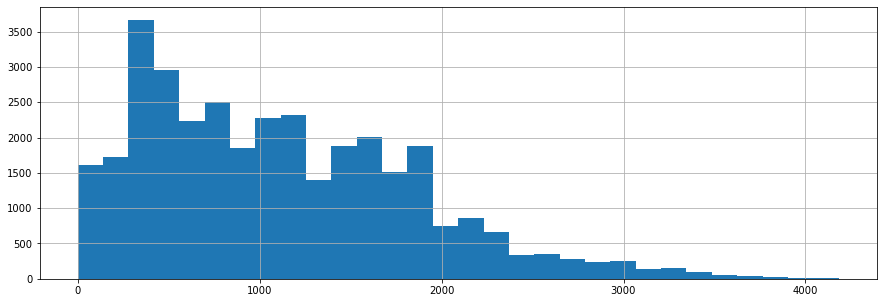

In [37]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [38]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [39]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

The same process will be followed for `last_review`:

In [40]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2020, 10, 5) - df.last_review).astype('timedelta64[D]')

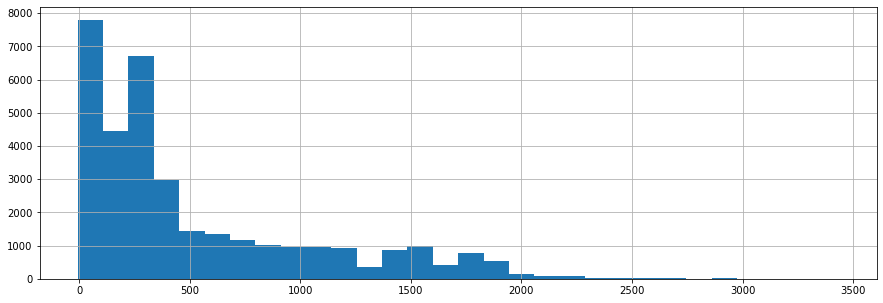

In [41]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [42]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [43]:
# Dropping first_review and last_review
df.drop(['first_review', 'last_review'], axis=1, inplace=True)

#### review ratings columns

Listings without reviews will be kept and replaced with `unknown`. Other ratings will be grouped into bins.

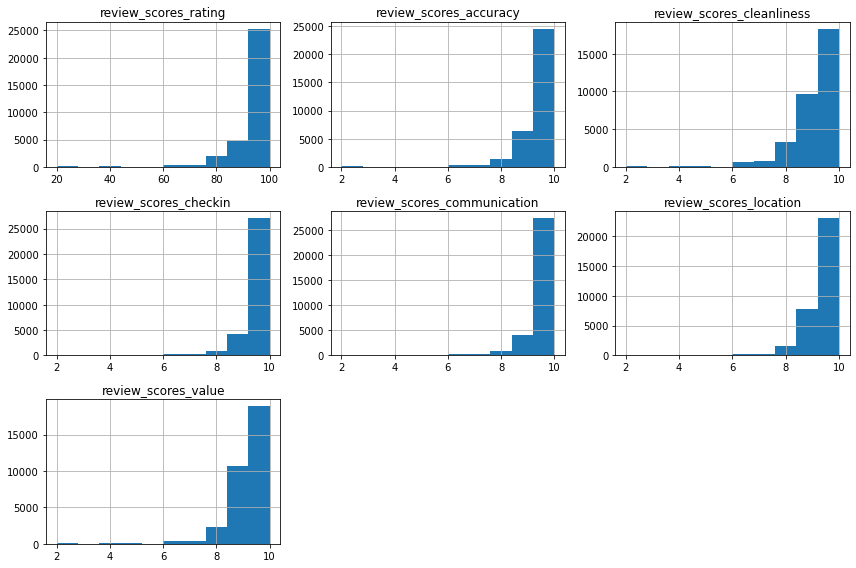

In [44]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [45]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [46]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [47]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

#### number_of_reviews_ltm, number_of_reviews_l30d, and reviews_per_month

These will be highly correlated with `number_of_reviews` and so will be dropped.

In [48]:
df.drop(['number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month'], axis=1, inplace=True)

***
## Preparing the data for modeling

### Dropping columns and assessing multi-collinearity

Categorical variables will now be one-hot encoded:

In [49]:
df.drop('host_since', axis=1, inplace=True)
transformed_df = pd.get_dummies(df)

The dataset will now be assessed for multi-collinearity.

In [50]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

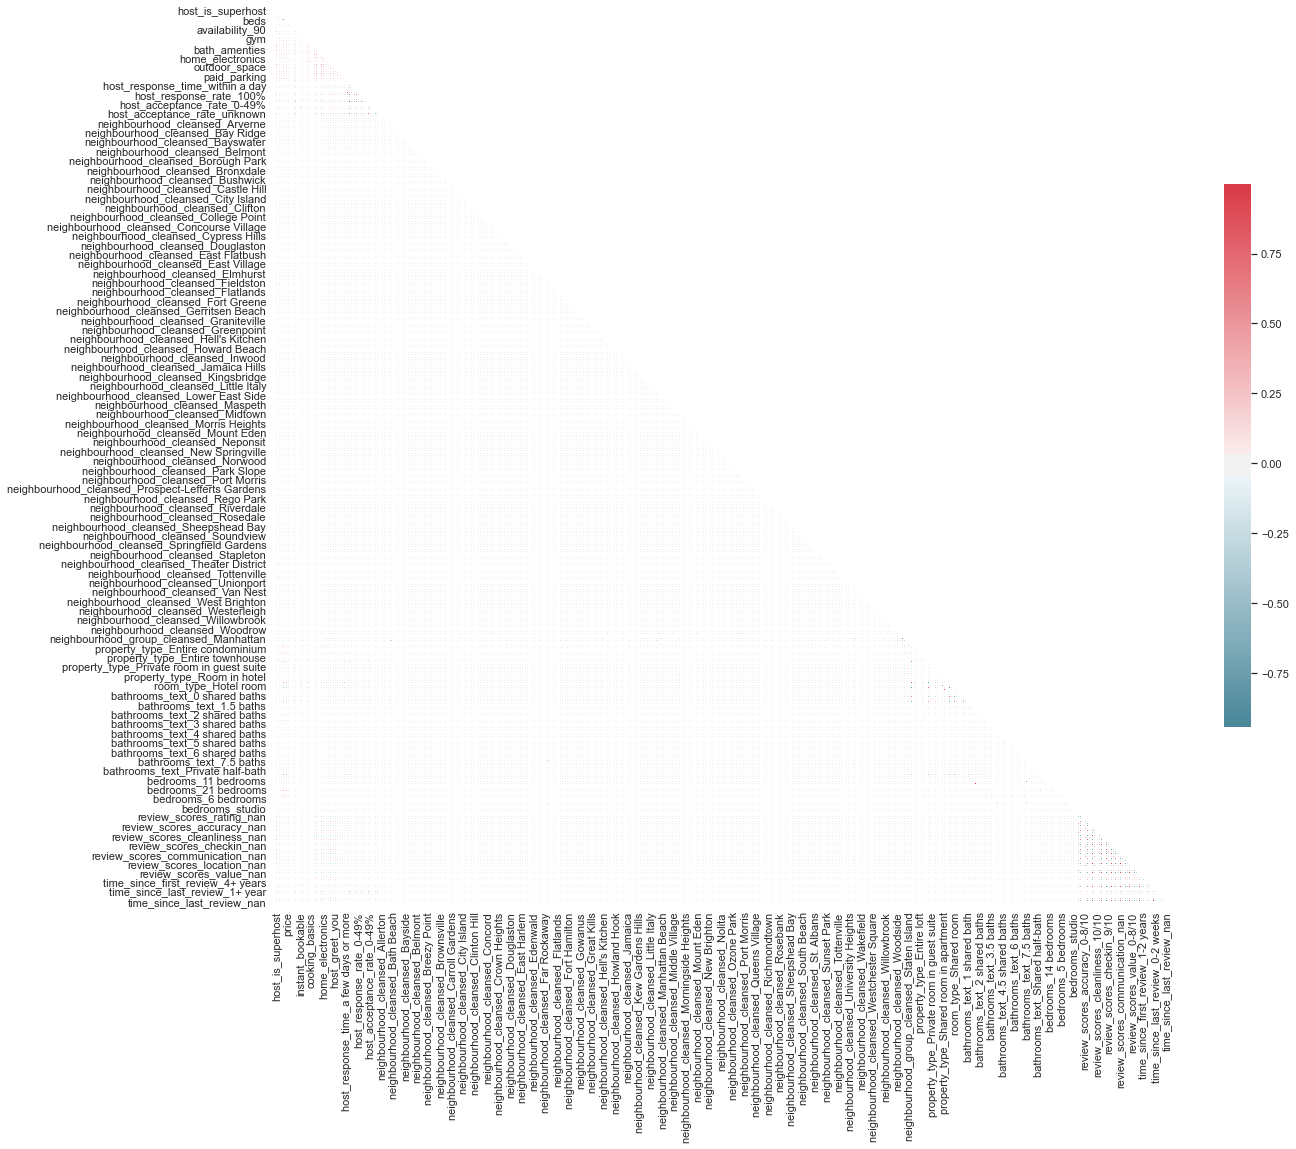

In [51]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

It doesn't look like there are any significant collinear relationships with neighborhoods, so these will temporarily be dropped for a clearer heatmap for the remaining features:

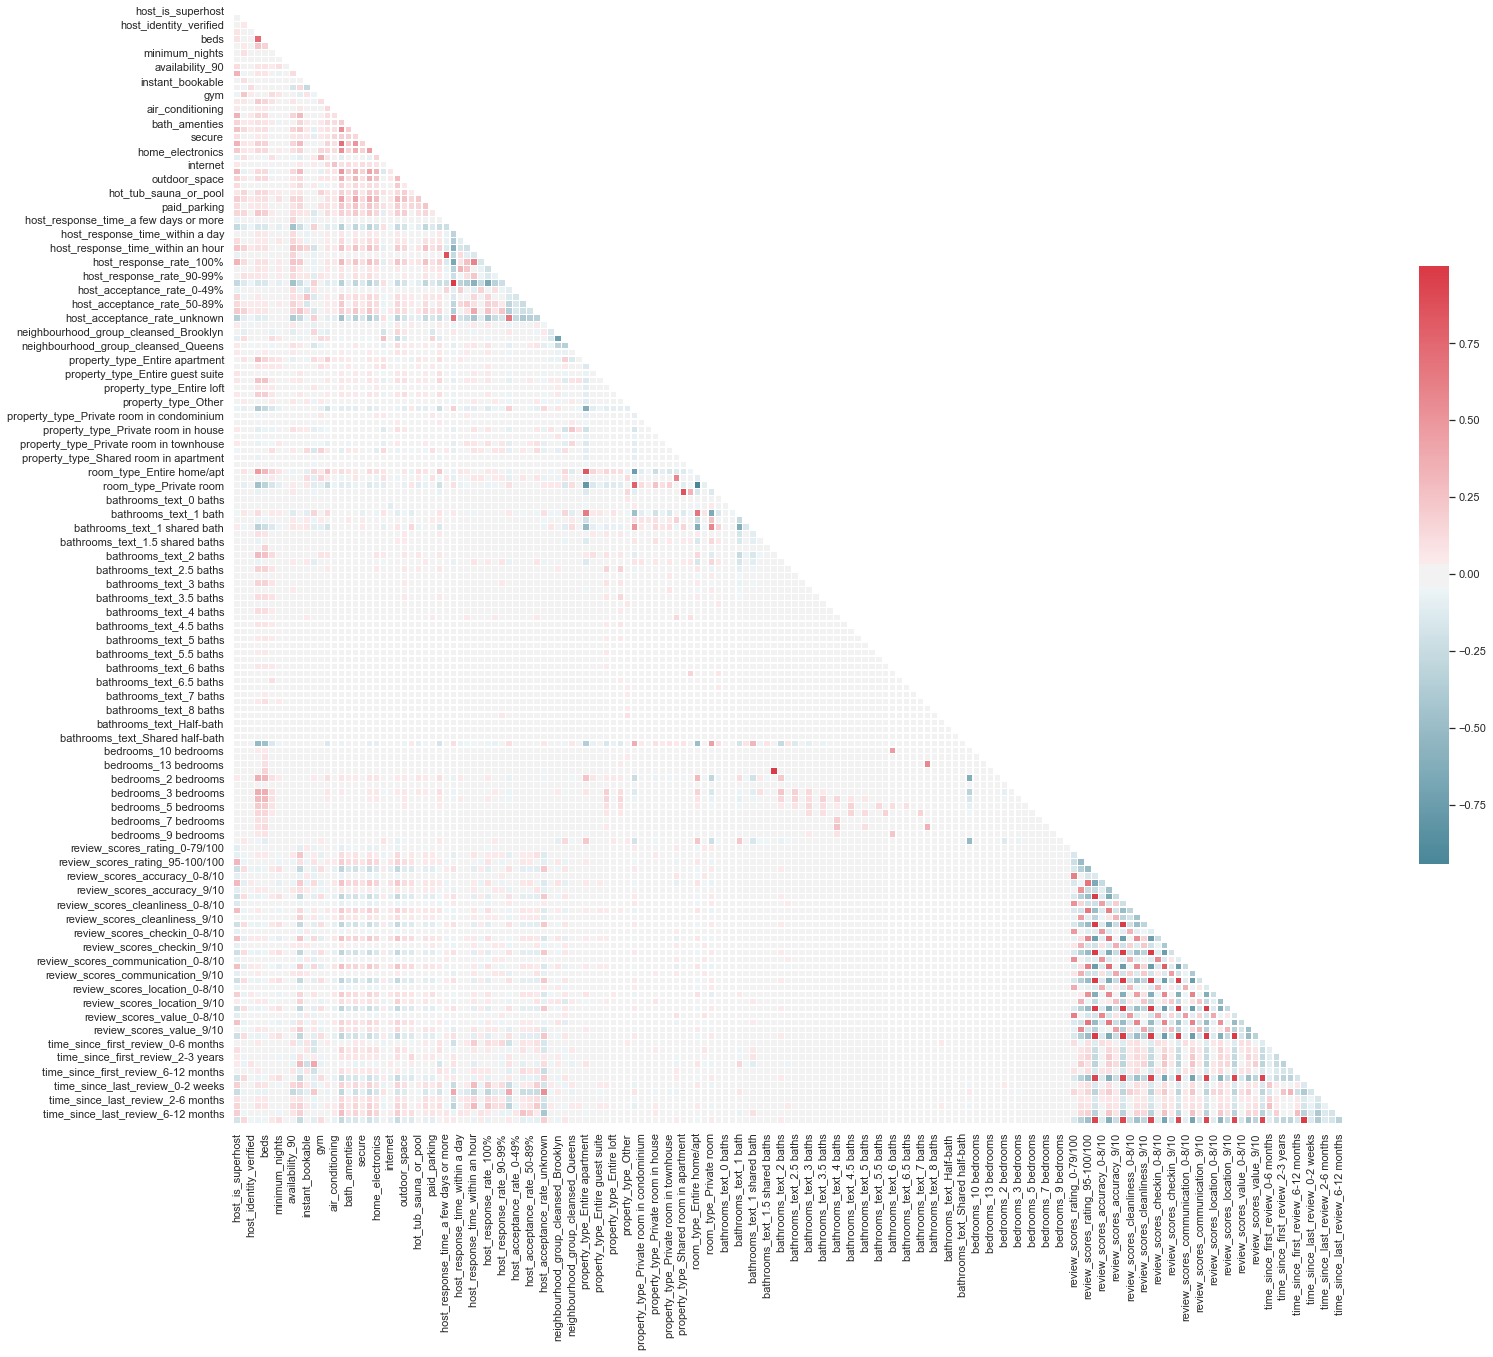

In [52]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood_cleansed')]), axis=1), figsize=(25,22))

It looks like there are some colinearity among review scores related features. Will keep them for now.

### Standardizing and normalizing

Other than `availability_90` and `host_days_active`, the numerical features are all postively skewed and could benefit from log transformation.

In [53]:
numerical_columns = ['host_listings_count', 'accommodates', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_90', 'number_of_reviews', 'host_days_active']

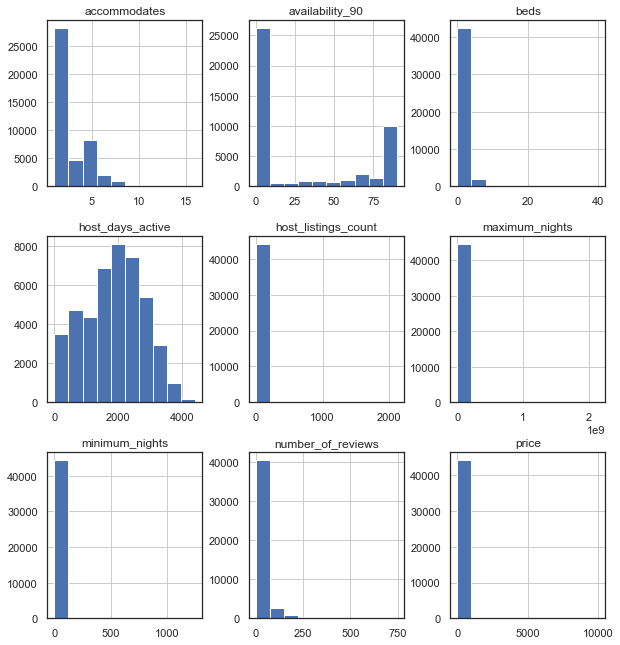

In [54]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [55]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

The target variable `price` is much more normally distributed after log transformation:

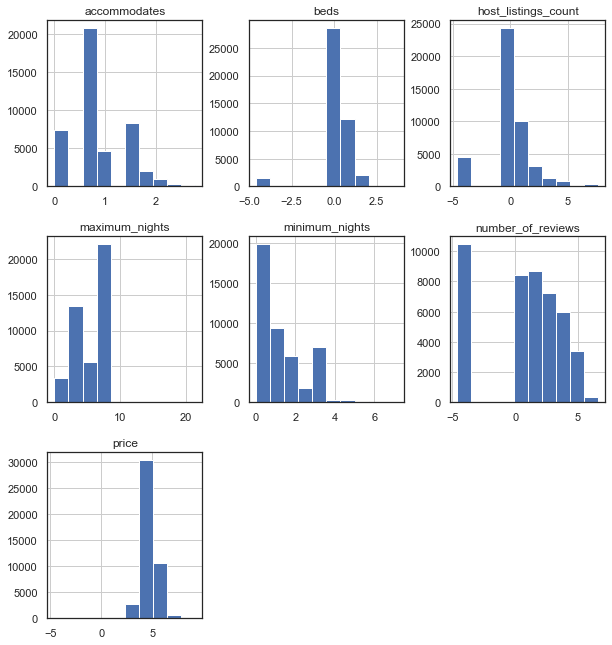

In [56]:
transformed_df[numerical_columns].hist(figsize=(10,11));

Separate the predictive features X and the target feature y and then standardize X using StandardScaler:

In [57]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

***
## Modeling 

We will build several regression models that predict an Airbnb listing's price using various machine learning and deep learning methods.

The evaluation metrics used will be mean squared error (for loss) and r-squared (for accuracy).

In [58]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Model 1: Ridge Regression 

Linear regression with L2 regularization.

Time taken to run: 0.0 minutes

Training MSE: 0.1931
Test MSE: 0.205937

Training r2: 0.6344
Test r2: 0.616738


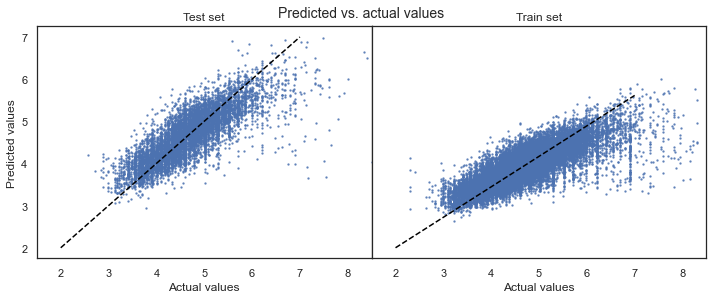

In [59]:
ridge_reg_start = time.time()

alpha = 100
ridge_reg = linear_model.Ridge(alpha=alpha)
ridge_reg.fit(X_train, y_train)
training_preds_ridge_reg = ridge_reg.predict(X_train)
val_preds_ridge_reg = ridge_reg.predict(X_test)

ridge_reg_end = time.time()

print(f"Time taken to run: {round((ridge_reg_end - ridge_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_ridge_reg),4))
print("Test MSE:", round(mean_squared_error(y_test, val_preds_ridge_reg), 6))
print("\nTraining r2:", round(r2_score(y_train, training_preds_ridge_reg),4))
print("Test r2:", round(r2_score(y_test, val_preds_ridge_reg), 6))

# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

ax1.scatter(y_test, val_preds_ridge_reg, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
ax1.set_xlim((1.5,8.5))

ax2.scatter(y_train, training_preds_ridge_reg, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
ax2.set_xlim((1.5,8.5))

plt.show()

### Model 2: Lasso Regression

Linear regression with L1 regularization.

Time taken to run: 0.2 minutes

Training MSE: 0.1937
Test MSE: 0.205702

Training r2: 0.6334
Test r2: 0.617174


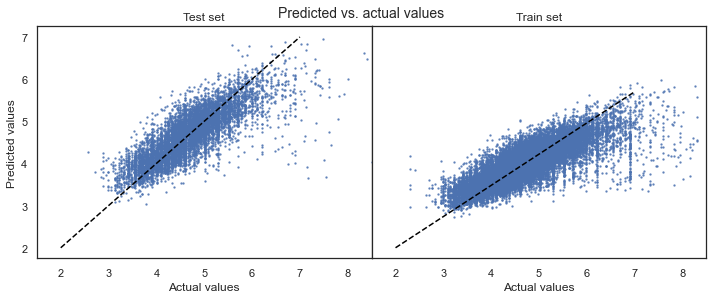

In [60]:
lasso_reg_start = time.time()

alpha = 0.001
lasso_reg = linear_model.Lasso(alpha=alpha)
lasso_reg.fit(X_train, y_train)
training_preds_lasso_reg = lasso_reg.predict(X_train)
val_preds_lasso_reg = lasso_reg.predict(X_test)

lasso_reg_end = time.time()

print(f"Time taken to run: {round((lasso_reg_end - lasso_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_lasso_reg),4))
print("Test MSE:", round(mean_squared_error(y_test, val_preds_lasso_reg), 6))
print("\nTraining r2:", round(r2_score(y_train, training_preds_lasso_reg),4))
print("Test r2:", round(r2_score(y_test, val_preds_lasso_reg), 6))

# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

ax1.scatter(y_test, val_preds_lasso_reg, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
ax1.set_xlim((1.5,8.5))

ax2.scatter(y_train, training_preds_lasso_reg, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
ax2.set_xlim((1.5,8.5))

plt.show()

### Model 3: ElasticNet Regression

Linear regression with combined L1 and L2 regularization.

Time taken to run: 0.1 minutes

Training MSE: 0.1933
Test MSE: 0.205713

Training r2: 0.634
Test r2: 0.617154


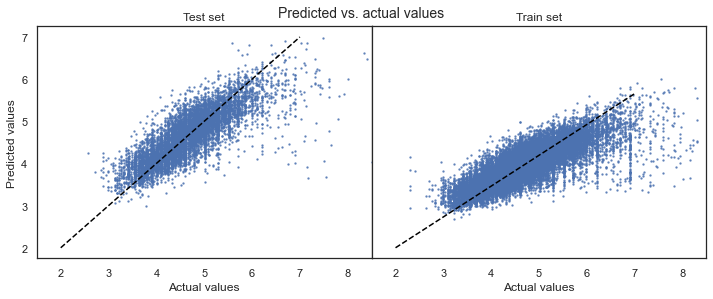

In [61]:
elasticnet_reg_start = time.time()

alpha = 0.001
elasticnet_reg = linear_model.ElasticNet(alpha=alpha)
elasticnet_reg.fit(X_train, y_train)
training_preds_elasticnet_reg = elasticnet_reg.predict(X_train)
val_preds_elasticnet_reg = elasticnet_reg.predict(X_test)

elasticnet_reg_end = time.time()

print(f"Time taken to run: {round((elasticnet_reg_end - elasticnet_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_elasticnet_reg),4))
print("Test MSE:", round(mean_squared_error(y_test, val_preds_elasticnet_reg), 6))
print("\nTraining r2:", round(r2_score(y_train, training_preds_elasticnet_reg),4))
print("Test r2:", round(r2_score(y_test, val_preds_elasticnet_reg), 6))

# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

ax1.scatter(y_test, val_preds_elasticnet_reg, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
ax1.set_xlim((1.5,8.5))

ax2.scatter(y_train, training_preds_elasticnet_reg, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
ax2.set_xlim((1.5,8.5))

plt.show()

### Model 4: XGBoost

Gradient-boosted decision trees. XGBoost provides a measure of feature importance.

Time taken to run: 0.3 minutes

Training MSE: 0.1128
Test MSE: 0.1768

Training r2: 0.7864
Test r2: 0.671


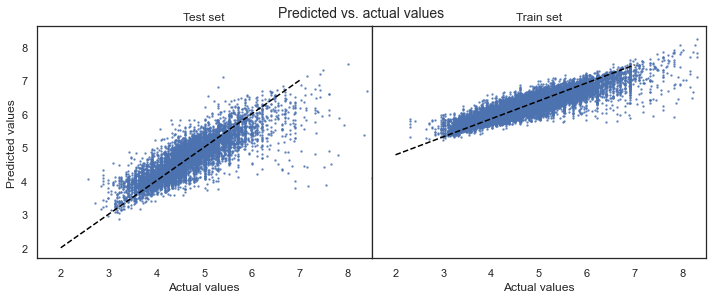

In [62]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Test MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

ax1.scatter(y_test, val_preds_xgb_reg, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
ax1.set_xlim((1.5,8.5))

ax2.scatter(y_train, training_preds_xgb_reg, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
ax2.set_xlim((1.5,8.5))

plt.show()

In [63]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg

weight
room_type_Entire home/apt                  0.426371
property_type_Room in hotel                0.058823
bathrooms_text_1 bath                      0.055885
neighbourhood_group_cleansed_Manhattan     0.031845
review_scores_communication_9/10           0.011474
...                                             ...
neighbourhood_cleansed_Concourse           0.000000
neighbourhood_cleansed_University Heights  0.000000
neighbourhood_cleansed_Concord             0.000000
neighbourhood_cleansed_Van Nest            0.000000
neighbourhood_cleansed_North Riverdale     0.000000

[380 rows x 1 columns]

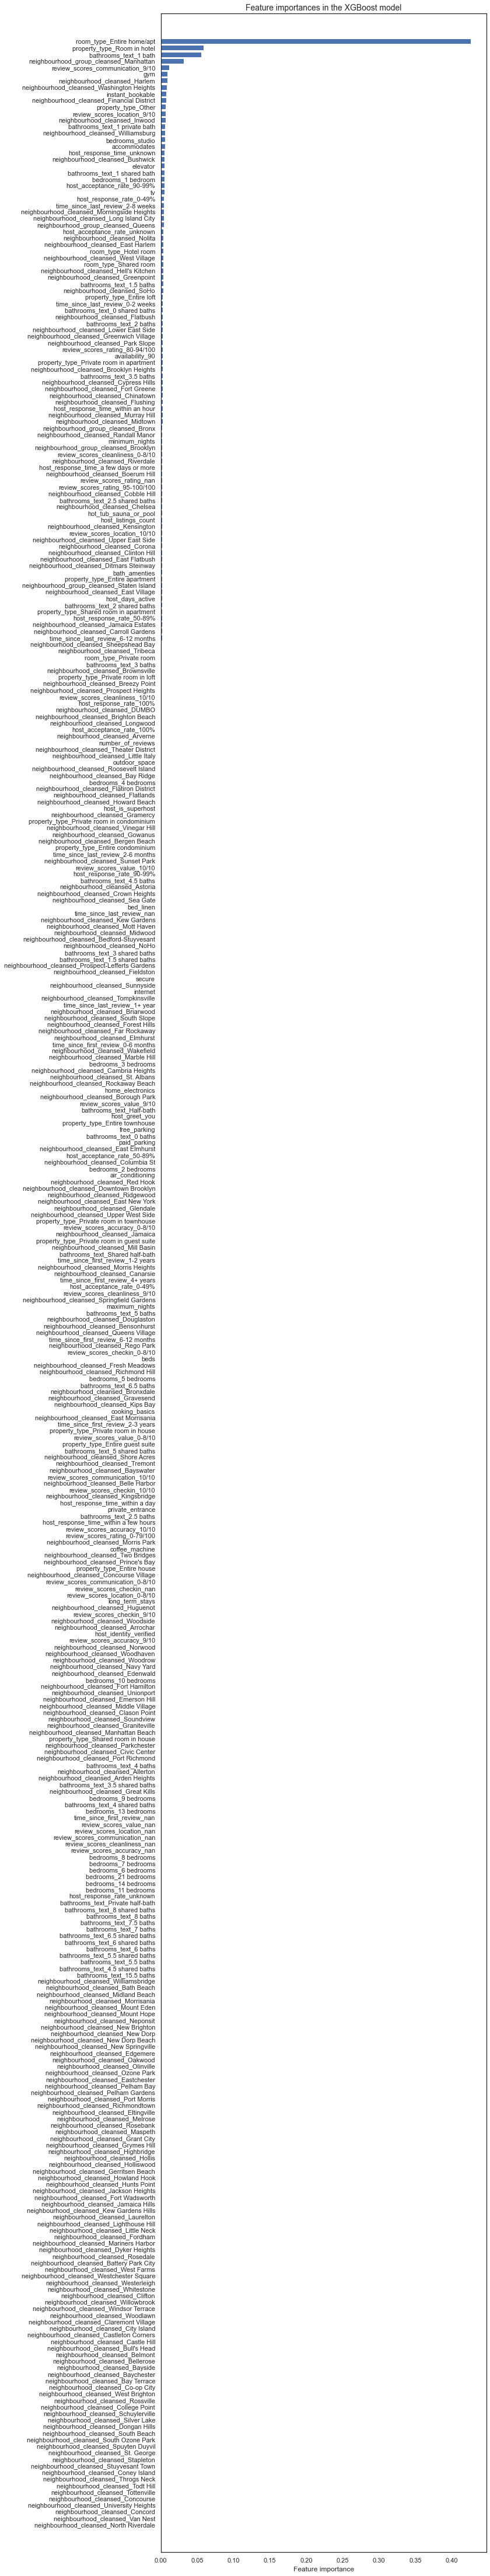

In [64]:
# Plotting feature importances
plt.figure(figsize=(10,80))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.gca().invert_yaxis()
plt.show()

Time taken to run: 0.3 minutes

Training MSE: 0.1128
Test MSE: 0.1768

Training r2: 0.7864
Test r2: 0.671

Training adjusted r2: 0.7841
Test adjusted r2: 0.6563


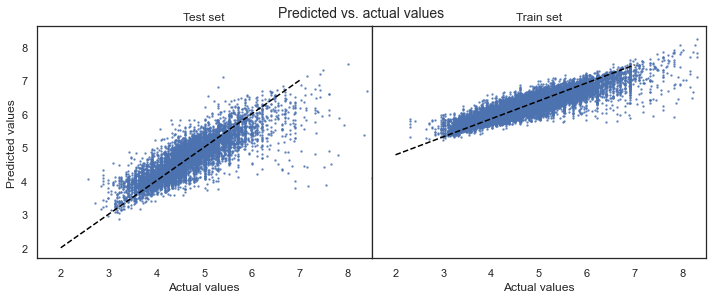

In [65]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Test MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test, val_preds_xgb_reg),4))
print("\nTraining adjusted r2:", round(1-(1-r2_score(y_train, training_preds_xgb_reg))*((int(X_train.shape[0])-1)/(int(X_train.shape[0])-int(X_train.shape[1])-1)),4))
print("Test adjusted r2:", round(1-(1-r2_score(y_test, val_preds_xgb_reg))*((int(X_test.shape[0])-1)/(int(X_test.shape[0])-int(X_test.shape[1])-1)),4))

# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

ax1.scatter(y_test, val_preds_xgb_reg, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
ax1.set_xlim((1.5,8.5))

ax2.scatter(y_train, training_preds_xgb_reg, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
ax2.set_xlim((1.5,8.5))

plt.show()

### Model 5: Four-Layer Neural Network with L1 Regularization

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               48768     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 279,681
Trainable params: 279,681
Non-trainable params: 0
_________________________________________________________________
None


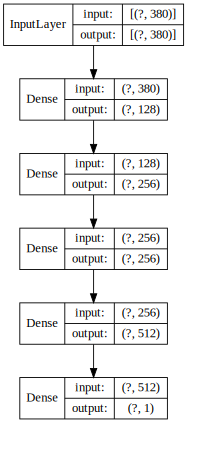

In [66]:
# Building the model
nn5 = models.Sequential()
nn5.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn5.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn5.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn5.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn5.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

# Visualising the neural network
SVG(model_to_dot(nn5, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [67]:
# Training the model
nn5_start = time.time()

nn5_history = nn5.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn5_end = time.time()

print(f"Time taken to run: {round((nn5_end - nn5_start)/60,1)} minutes")

Epoch 1/150
126/126 [==============================] - 1s 6ms/step - loss: 42.9227 - mean_squared_error: 1.6547 - val_loss: 21.8751 - val_mean_squared_error: 0.2468
Epoch 2/150
126/126 [==============================] - 1s 4ms/step - loss: 14.6949 - mean_squared_error: 0.2476 - val_loss: 9.5319 - val_mean_squared_error: 0.2106
Epoch 3/150
126/126 [==============================] - 0s 4ms/step - loss: 6.8931 - mean_squared_error: 0.2271 - val_loss: 4.8230 - val_mean_squared_error: 0.2109
Epoch 4/150
126/126 [==============================] - 1s 4ms/step - loss: 3.6258 - mean_squared_error: 0.2267 - val_loss: 2.6363 - val_mean_squared_error: 0.2119
Epoch 5/150
126/126 [==============================] - 1s 7ms/step - loss: 2.0466 - mean_squared_error: 0.2242 - val_loss: 1.5352 - val_mean_squared_error: 0.2050
Epoch 6/150
126/126 [==============================] - 1s 6ms/step - loss: 1.2429 - mean_squared_error: 0.2163 - val_loss: 0.9795 - val_mean_squared_error: 0.1991
Epoch 7/150
126/126

Epoch 51/150
126/126 [==============================] - 1s 7ms/step - loss: 0.3938 - mean_squared_error: 0.2025 - val_loss: 0.3821 - val_mean_squared_error: 0.1895
Epoch 52/150
126/126 [==============================] - 1s 4ms/step - loss: 0.3940 - mean_squared_error: 0.2028 - val_loss: 0.3810 - val_mean_squared_error: 0.1903
Epoch 53/150
126/126 [==============================] - 1s 5ms/step - loss: 0.3937 - mean_squared_error: 0.2029 - val_loss: 0.3827 - val_mean_squared_error: 0.1921
Epoch 54/150
126/126 [==============================] - 1s 6ms/step - loss: 0.3939 - mean_squared_error: 0.2033 - val_loss: 0.3838 - val_mean_squared_error: 0.1911
Epoch 55/150
126/126 [==============================] - 1s 5ms/step - loss: 0.3945 - mean_squared_error: 0.2036 - val_loss: 0.3792 - val_mean_squared_error: 0.1888
Epoch 56/150
126/126 [==============================] - 1s 7ms/step - loss: 0.3923 - mean_squared_error: 0.2028 - val_loss: 0.3805 - val_mean_squared_error: 0.1898
Epoch 57/150
126

Epoch 101/150
126/126 [==============================] - 0s 4ms/step - loss: 0.3886 - mean_squared_error: 0.2022 - val_loss: 0.3748 - val_mean_squared_error: 0.1884
Epoch 102/150
126/126 [==============================] - 0s 4ms/step - loss: 0.3886 - mean_squared_error: 0.2022 - val_loss: 0.3776 - val_mean_squared_error: 0.1907
Epoch 103/150
126/126 [==============================] - 0s 4ms/step - loss: 0.3888 - mean_squared_error: 0.2023 - val_loss: 0.3786 - val_mean_squared_error: 0.1922
Epoch 104/150
126/126 [==============================] - 1s 4ms/step - loss: 0.3892 - mean_squared_error: 0.2026 - val_loss: 0.3751 - val_mean_squared_error: 0.1888
Epoch 105/150
126/126 [==============================] - 0s 4ms/step - loss: 0.3883 - mean_squared_error: 0.2021 - val_loss: 0.3751 - val_mean_squared_error: 0.1884
Epoch 106/150
126/126 [==============================] - 0s 4ms/step - loss: 0.3889 - mean_squared_error: 0.2028 - val_loss: 0.3763 - val_mean_squared_error: 0.1901
Epoch 107/

126/126 [==============================] - 0s 4ms/step - loss: 0.3846 - mean_squared_error: 0.2024 - val_loss: 0.3713 - val_mean_squared_error: 0.1889
Time taken to run: 1.5 minutes


In [68]:
def nn_model_evaluation(model, nn_history, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Test MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Test r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = nn_history.history
    
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    ax1.set_xlim((1.5,8.5))
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    ax2.set_xlim((1.5,8.5))
    
    plt.show()

Training MSE: 0.199
Test MSE: 0.2107

Training r2: 0.6234
Test r2: 0.6079


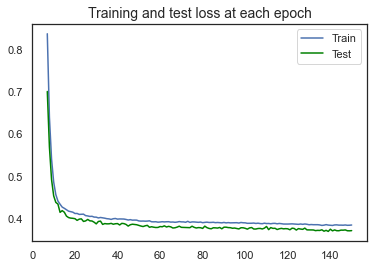

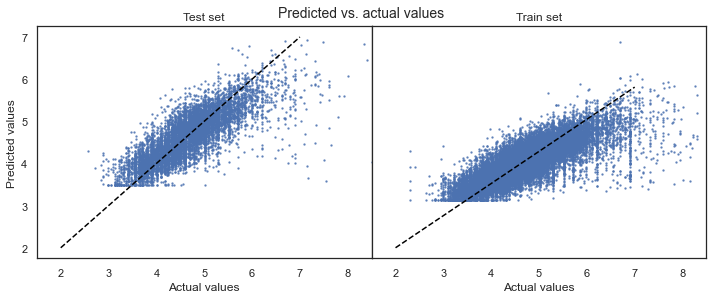

In [69]:
# Evaluating the model
nn_model_evaluation(nn5, nn_history=nn5_history, skip_epochs=6)

### Model 6: Improved Neural Network with Some Colinear Features Removed

Building neural network again after drropping the review columns which were found to be highly correlated with each other.

In [70]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               45696     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 276,609
Trainable params: 276,609
Non-trainable params: 0
_________________________________________________________________
None


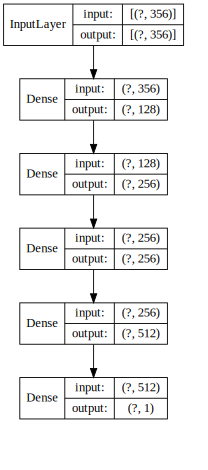

In [71]:
# Building the model
nn6 = models.Sequential()
nn6.add(layers.Dense(128, input_shape=(X_train_short.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn6.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn6.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn6.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn6.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn6.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn6.summary())

# Visualising the neural network
SVG(model_to_dot(nn6, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [72]:
# Training the model
nn6_start = time.time()

nn6_history = nn6.fit(X_train_short,
                  y_train,
                  epochs=50,
                  batch_size=256,
                  validation_split=0.1)

nn6_end = time.time()

print(f"Time taken to run: {round((nn6_end - nn6_start)/60,1)} minutes")

Epoch 1/50
126/126 [==============================] - 1s 7ms/step - loss: 43.1146 - mean_squared_error: 1.9116 - val_loss: 21.2130 - val_mean_squared_error: 0.2773
Epoch 2/50
126/126 [==============================] - 1s 4ms/step - loss: 13.3264 - mean_squared_error: 0.2481 - val_loss: 7.7710 - val_mean_squared_error: 0.2063
Epoch 3/50
126/126 [==============================] - 1s 5ms/step - loss: 5.1931 - mean_squared_error: 0.2136 - val_loss: 3.3062 - val_mean_squared_error: 0.2052
Epoch 4/50
126/126 [==============================] - 1s 4ms/step - loss: 2.3717 - mean_squared_error: 0.2212 - val_loss: 1.6625 - val_mean_squared_error: 0.2180
Epoch 5/50
126/126 [==============================] - 0s 4ms/step - loss: 1.2950 - mean_squared_error: 0.2257 - val_loss: 0.9870 - val_mean_squared_error: 0.2081
Epoch 6/50
126/126 [==============================] - 1s 6ms/step - loss: 0.8303 - mean_squared_error: 0.2157 - val_loss: 0.6825 - val_mean_squared_error: 0.1967
Epoch 7/50
126/126 [=====

Training MSE: 0.2005
Test MSE: 0.2118

Training r2: 0.6206
Test r2: 0.6057


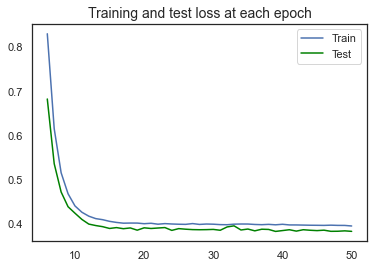

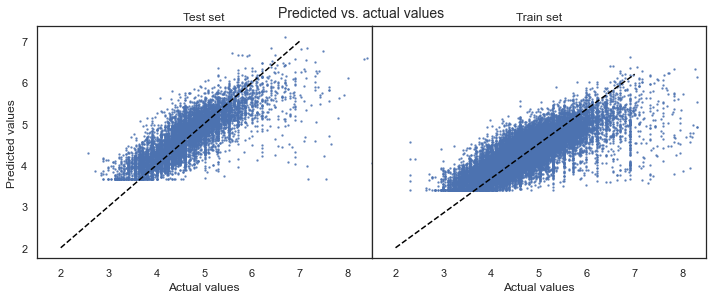

In [73]:
nn_model_evaluation(nn6, nn_history=nn6_history, skip_epochs=5, X_train=X_train_short, X_test=X_test_short)

### Model selection

- The XGBoost model (Model 4) is the selected model, which performed better than other models.
- The XGBoost model was able to explain 67% of the variation in price.

***
## Model improvement #1: Incorporate topic modeling for property descriptions

We will try to improve the model by incorporating the topic models from property descriptions as an additional input to the model.

### Topic models

In [74]:
import string
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.style import set_palette
from yellowbrick.text.freqdist import FreqDistVisualizer
import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

In [75]:
l = pd.read_csv('data/insideairbnb-nyc-10-05-20/listings.csv', encoding='utf-8')
description = l['description']
# set 'id' as index for joining with the original df later
l.set_index('id', inplace=True)

In [76]:
# Should run experiment on both na and not na features to see if na values affect the result.
# CountVect doesn't work with na
description.isna().sum()
d = description.dropna()

In [77]:
vect = CountVectorizer(stop_words='english')
d_docs = vect.fit_transform(d)
features = vect.get_feature_names()

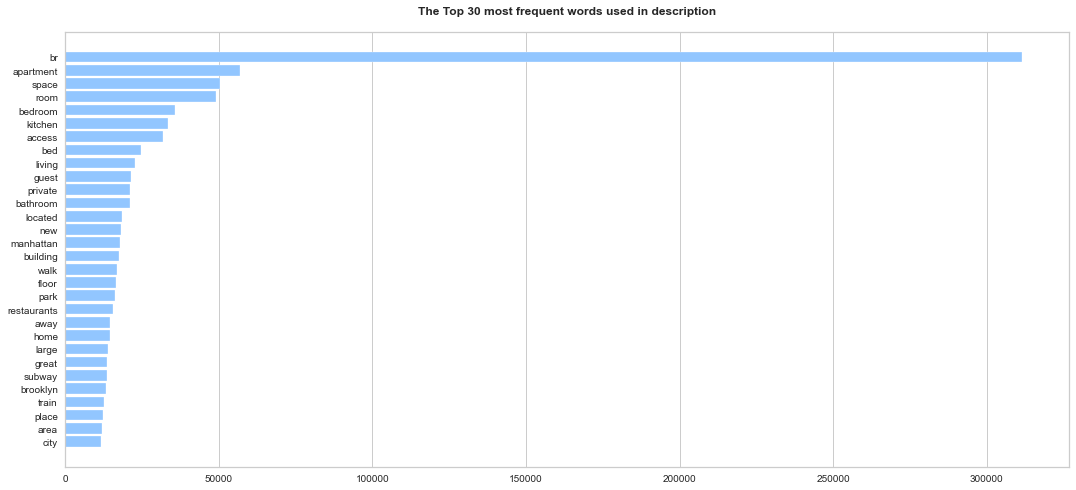

In [78]:
set_palette('sns_pastel')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in description\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(d_docs)
visualizer.poof;

In [79]:
def clean(corpus):
    doc = []
    english_words = set(words.words())
    english_stopwords = set(stopwords.words('english'))
    punc = set(string.punctuation)
    lemma = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[\w|!]+')
    for row in corpus:
        word_tokens = tokenizer.tokenize(row)
        word_tokens_lower = [t.lower() for t in word_tokens]
        word_tokens_lower_english = [t for t in word_tokens_lower if t in english_words or not t.isalpha()]
        stop_free = [t for t in word_tokens_lower_english if not t in english_stopwords]
        punc_free = [t for t in stop_free if t not in punc]
        lemmatized = [lemma.lemmatize(t) for t in punc_free]
        doc.append(lemmatized)
    return doc

d1 = description.astype(str)
d2 = d.astype(str)
d1_clean = clean(d1)
d2_clean = clean(d2)

In [80]:
def model_dict(processed_corpus):
# Takes processed corpus and produce dictionary, doc_term_matrix and LDA model
    # Creates the term dictionary (every unique term in corpus is assigned an index)
    dictionary = Dictionary(processed_corpus)
    # Convert corpus into Document Term Matrix using dictionary prepared above
    doc_term_matrix = [dictionary.doc2bow(listing) for listing in processed_corpus]    
    return dictionary, doc_term_matrix

def topic_mod( dictionary,doc_term_matrix, num_topics, passes):
    # Create an object for LDA model and train it on Document-Term-Matrix
#     ldamodel = LdaModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=passes)
    # use LdaMulticore for faster processing
    ldamodel = LdaMulticore(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=passes)
    return ldamodel

def add_to_df(ldamodel, doc_term_matrix, df, new_col, num_topics):
    # Convert into Per-document topic probability matrix:
    docTopicProbMat = ldamodel[doc_term_matrix]
    docTopicProbDf = pd.DataFrame(index=df.index, columns=range(0, num_topics))
    for i, doc in enumerate(docTopicProbMat):
        for topic in doc:
            docTopicProbDf.iloc[i, topic[0]] = topic[1]
    docTopicProbDf=docTopicProbDf.apply(pd.to_numeric,errors = 'coerce', axis=0)
    docTopicProbDf[new_col] = docTopicProbDf.idxmax(axis=1)
    df_topics = docTopicProbDf[new_col]
    # Merge with df of other features, here I was using listing
    df_new = pd.concat([df, df_topics], axis=1)
    return df_new

In [81]:
d1, d1_mat= model_dict(d1_clean)

lda_start = time.time()
lda1=topic_mod(d1, d1_mat, 5, 10)
lda_end = time.time()

print(f"Time taken to run: {round((lda_end - lda_start)/60,1)} minutes")

Time taken to run: 1.6 minutes


In [82]:
add_start = time.time()
l1=add_to_df(lda1, d1_mat, l, 'topic', 5)
add_end = time.time()

print(f"Time taken to run: {round((lda_end - lda_start)/60,1)} minutes")

Time taken to run: 1.6 minutes


In [83]:
l1['topic'].value_counts()

2    14012
1    13585
4    10857
3     3275
0     2937
Name: topic, dtype: int64

In [84]:
l1['topic'].replace({
    0:'topic0',
    1:'topic1',
    2:'topic2',
    3:'topic3',
    4:'topic4'
},inplace=True)

### Adding topics to the original model as additional feature

In [85]:
# inner join two dfs
df_topic = df.join(l1['topic'], how='inner')

print(df.shape, l1.shape, df_topic.shape)

(44559, 48) (44666, 74) (44559, 49)


### Premodeling preparation:
- categorical features to one-hot encoded
- log transforming
- standardization
- split train and test set

In [86]:
transformed_df_topic = pd.get_dummies(df_topic)

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df_topic[col] = transformed_df_topic[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df_topic[col] = np.log(transformed_df_topic[col])

# Separating X and y
X_topic = transformed_df_topic.drop('price', axis=1)
y_topic = transformed_df_topic.price

# Scaling
scaler = StandardScaler()
X_topic = pd.DataFrame(scaler.fit_transform(X_topic), columns=list(X_topic.columns))

# Splitting into train and test sets
X_train_topic, X_test_topic, y_train_topic, y_test_topic = train_test_split(X_topic, y_topic, test_size=0.2, random_state=123)

### Run XGBoost model again with new feature (description topics)

Time taken to run: 0.3 minutes

Training MSE: 0.1116
Test MSE: 0.1755

Training r2: 0.7887
Test r2: 0.6734


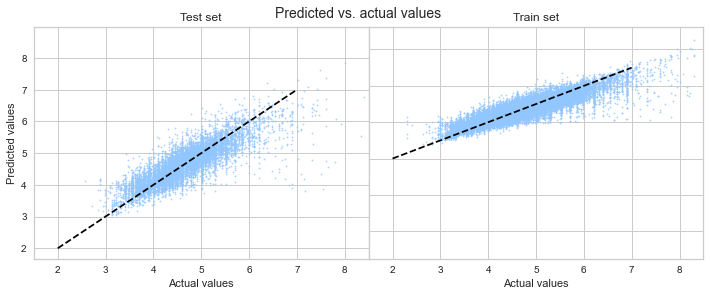

In [87]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_topic, y_train_topic)
training_preds_xgb_reg = xgb_reg.predict(X_train_topic)
val_preds_xgb_reg = xgb_reg.predict(X_test_topic)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train_topic, training_preds_xgb_reg),4))
print("Test MSE:", round(mean_squared_error(y_test_topic, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train_topic, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test_topic, val_preds_xgb_reg),4))

# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

ax1.scatter(y_test_topic, val_preds_xgb_reg, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
ax1.set_xlim((1.5,8.5))

ax2.scatter(y_train_topic, training_preds_xgb_reg, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
ax2.set_xlim((1.5,8.5))

plt.show()

Time taken to run: 0.3 minutes

Training MSE: 0.1116
Test MSE: 0.1755

Training r2: 0.7887
Test r2: 0.6734

Training adjusted r2: 0.7864
Test adjusted r2: 0.6586


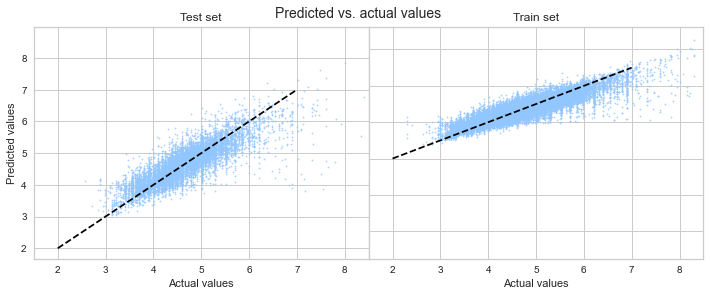

In [88]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_topic, y_train_topic)
training_preds_xgb_reg = xgb_reg.predict(X_train_topic)
val_preds_xgb_reg = xgb_reg.predict(X_test_topic)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train_topic, training_preds_xgb_reg),4))
print("Test MSE:", round(mean_squared_error(y_test_topic, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train_topic, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test_topic, val_preds_xgb_reg),4))
print("\nTraining adjusted r2:", round(1-(1-r2_score(y_train_topic, training_preds_xgb_reg))*((int(X_train_topic.shape[0])-1)/(int(X_train_topic.shape[0])-int(X_train_topic.shape[1])-1)),4))
print("Test adjusted r2:", round(1-(1-r2_score(y_test_topic, val_preds_xgb_reg))*((int(X_test_topic.shape[0])-1)/(int(X_test_topic.shape[0])-int(X_test_topic.shape[1])-1)),4))

# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

ax1.scatter(y_test_topic, val_preds_xgb_reg, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
ax1.set_xlim((1.5,8.5))

ax2.scatter(y_train_topic, training_preds_xgb_reg, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
ax2.set_xlim((1.5,8.5))

plt.show()

### Result
- After addding description topics as a feature, r-square has been slightly improved from 0.6710 to 0.6735.

***
## Model improvement #2: Incorporating sentiment analysis of user reviews

We will attempt to improve the model further by incorporating sentiment analysis on user reviews as an additional feature.

### Importing the libraries and data

In [89]:
from langdetect import detect
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [90]:
r = pd.read_csv('data/insideairbnb-nyc-10-05-20/reviews.csv', encoding='utf-8')
r

listing_id         id        date  reviewer_id reviewer_name  \
0              2595      17857  2009-11-21        50679          Jean   
1              2595      19176  2009-12-05        53267          Cate   
2              2595      19760  2009-12-10        38960         Anita   
3              2595      34320  2010-04-09        71130       Kai-Uwe   
4              2595      46312  2010-05-25       117113        Alicia   
...             ...        ...         ...          ...           ...   
1003059    45673803  671875113  2020-10-06    214135354           Min   
1003060    45676323  671588396  2020-10-05    290213978        Alyssa   
1003061    45702596  671894092  2020-10-06    296568971         Samba   
1003062    45712092  671859717  2020-10-06    191594508            Fm   
1003063    45714231  671844752  2020-10-06    169392013     Magdaline   

                                                  comments  
0        Notre séjour de trois nuits.\r\nNous avons app...  
1                                        Great experience.  
2        I've stayed with my friend at the Midtown Cast...  
3        We've been staying here for about 9 nights, en...  
4        We had a wonderful stay at Jennifer's charming...  
...                                                    ...  
1003059  Jo is very accommodating and helpful. She answ...  
1003060  Travis was an outstanding host! He made sure e...  
1003061                                        Good place.  
1003062         I would recommend this place for everyone.  
1003063                  A great, quiet and peaceful stay.  

[1003064 rows x 6 columns]

In [91]:
df_topic

host_response_time host_response_rate host_acceptance_rate  \
id                                                                     
2595            within a day             50-89%                0-49%   
3831          within an hour             90-99%               90-99%   
5136      within a few hours               100%              unknown   
5178      within a few hours               100%                 100%   
5203                 unknown            unknown              unknown   
...                      ...                ...                  ...   
45724439      within an hour               100%              unknown   
45725790      within an hour               100%                 100%   
45726160  within a few hours               100%                 100%   
45726522  within a few hours               100%               50-89%   
45730924      within an hour               100%               50-89%   

          host_is_superhost  host_listings_count  host_identity_verified  \
id                                                                         
2595                    0.0                  6.0                     1.0   
3831                    0.0                  1.0                     1.0   
5136                    0.0                  1.0                     0.0   
5178                    0.0                  1.0                     0.0   
5203                    0.0                  1.0                     1.0   
...                     ...                  ...                     ...   
45724439                0.0                  0.0                     1.0   
45725790                0.0                  0.0                     1.0   
45726160                0.0                  0.0                     1.0   
45726522                1.0                  1.0                     1.0   
45730924                0.0                  1.0                     1.0   

             neighbourhood_cleansed neighbourhood_group_cleansed  \
id                                                                 
2595                        Midtown                    Manhattan   
3831                   Clinton Hill                     Brooklyn   
5136                    Sunset Park                     Brooklyn   
5178                 Hell's Kitchen                    Manhattan   
5203                Upper West Side                    Manhattan   
...                             ...                          ...   
45724439            Upper East Side                    Manhattan   
45725790            Lower East Side                    Manhattan   
45726160  Prospect-Lefferts Gardens                     Brooklyn   
45726522                     Harlem                    Manhattan   
45730924                  Chinatown                    Manhattan   

                      property_type        room_type  accommodates  \
id                                                                   
2595               Entire apartment  Entire home/apt             2   
3831             Entire guest suite  Entire home/apt             3   
5136               Entire apartment  Entire home/apt             4   
5178      Private room in apartment     Private room             2   
5203      Private room in apartment     Private room             1   
...                             ...              ...           ...   
45724439  Private room in apartment     Private room             1   
45725790           Entire apartment  Entire home/apt             4   
45726160           Entire apartment  Entire home/apt             4   
45726522  Private room in apartment     Private room             3   
45730924  Private room in apartment     Private room             1   

         bathrooms_text    bedrooms  beds  price  minimum_nights  \
id                                                                 
2595             1 bath      studio   1.0    175               3   
3831             1 bath   1 bedroom   3.0     76               1   
5136          1.

In [92]:
# convert index of df_topic into a column for merge with review dataframe
df_topic['listing_id'] = df_topic.index

# merge two dataframes
df2 = pd.merge(r, df_topic, left_on='listing_id', right_on='listing_id', how='left')

In [93]:
df2.dropna(inplace=True)

In [94]:
# function that detects the language
def lang_detect(text):
    try:
        return detect(text)
    except:
        return None

In [95]:
# apply the function and store values in a new column
df2['language'] = df2['comments'].apply(lang_detect)

In [96]:
vect = CountVectorizer(stop_words='english')
re_docs = vect.fit_transform(df2['comments'])
re_features = vect.get_feature_names()

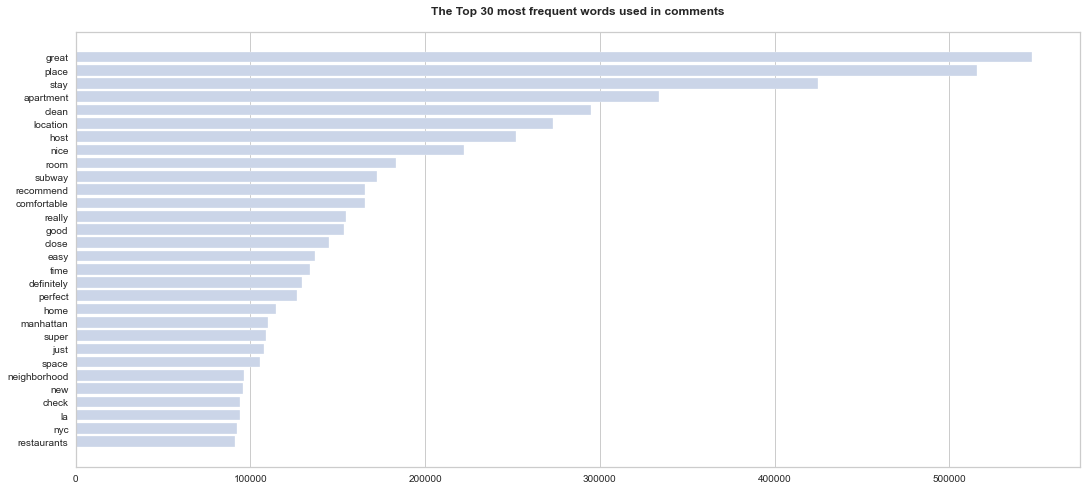

In [97]:
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=re_features, n=30)
visualizer.fit(re_docs)
visualizer.poof;

In [98]:
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [99]:
# create a new dataframe containing only English comments
df2_eng = df2[(df2['language']=='en')]

# produce all four sentiment scores for each of comments.
analyzer = SentimentIntensityAnalyzer()
df2_eng['sentiment_neg'] = df2_eng['comments'].apply(negative_score)
df2_eng['sentiment_neu'] = df2_eng['comments'].apply(neutral_score)
df2_eng['sentiment_pos'] = df2_eng['comments'].apply(positive_score)
df2_eng['sentiment_compound'] = df2_eng['comments'].apply(compound_score)

# generate percentiles of our dataset’s compound score:
percentiles = df2_eng.sentiment_compound.describe(percentiles=[.05, .1, .2, .3, .4, .5, .6, .7, .8, .9])
percentiles

count    882775.000000
mean          0.819856
std           0.266927
min          -0.999000
5%            0.248100
10%           0.568600
20%           0.750100
30%           0.839500
40%           0.888300
50%           0.919900
60%           0.941800
70%           0.958200
80%           0.971200
90%           0.982600
max           0.999700
Name: sentiment_compound, dtype: float64

In [100]:
# assign the data
neg = percentiles['5%']
mid = percentiles['20%']
pos = percentiles['max']
names = ['Negative Comments', 'Mixed Comments','Positive Comments']
size = [neg, mid, pos]

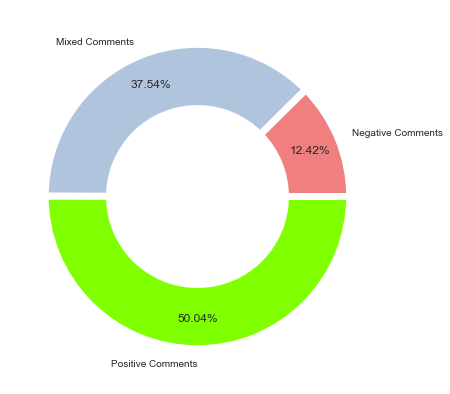

In [101]:
# call a pie chart
plt.pie(size, labels=names, colors=['lightcoral', 'lightsteelblue', 'chartreuse'], 
        autopct='%.2f%%', pctdistance=0.8,
        wedgeprops={'linewidth':7, 'edgecolor':'white' })

circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(circle)
plt.show()

In [102]:
df2_eng

listing_id         id        date  reviewer_id reviewer_name  \
2              2595      19760  2009-12-10        38960         Anita   
3              2595      34320  2010-04-09        71130       Kai-Uwe   
4              2595      46312  2010-05-25       117113        Alicia   
5              2595    1238204  2012-05-07      1783688        Sergey   
6              2595    1293632  2012-05-17      1870771          Loïc   
...             ...        ...         ...          ...           ...   
1003059    45673803  671875113  2020-10-06    214135354           Min   
1003060    45676323  671588396  2020-10-05    290213978        Alyssa   
1003061    45702596  671894092  2020-10-06    296568971         Samba   
1003062    45712092  671859717  2020-10-06    191594508            Fm   
1003063    45714231  671844752  2020-10-06    169392013     Magdaline   

                                                  comments host_response_time  \
2        I've stayed with my friend at the Midtown Cast...       within a day   
3        We've been staying here for about 9 nights, en...       within a day   
4        We had a wonderful stay at Jennifer's charming...       within a day   
5        Hi to everyone!\r\nWould say our greatest comp...       within a day   
6        Jennifer was very friendly and helpful, and he...       within a day   
...                                                    ...                ...   
1003059  Jo is very accommodating and helpful. She answ...     within an hour   
1003060  Travis was an outstanding host! He made sure e...     within an hour   
1003061                                        Good place.     within an hour   
1003062         I would recommend this place for everyone.     within an hour   
1003063                  A great, quiet and peaceful stay.     within an hour   

        host_response_rate host_acceptance_rate  host_is_superhost  \
2                   50-89%                0-49%                0.0   
3                   50-89%                0-49%                0.0   
4                   50-89%                0-49%                0.0   
5                   50-89%                0-49%                0.0   
6                   50-89%                0-49%                0.0   
...                    ...                  ...                ...   
1003059               100%                 100%                0.0   
1003060             90-99%               90-99%                0.0   
1003061               100%                 100%                0.0   
1003062               100%                 100%                0.0   
1003063               100%               90-99%                0.0   

         host_listings_count  host_identity_verified neighbourhood_cleansed  \
2                        6.0                     1.0                Midtown   
3                        6.0                     1.0                Midtown   
4                        6.0                     1.0                Midtown   
5                        6.0                     1.0                Midtown   
6                        6.0                     1.0                Midtown   
...                      ...                     ...                    ...   
1003059                  0.0                     1.0        Upper East Side   
1003060                  0.0                     0.0          Cypress Hills   
1003061                  5.0                     1.0          East Elmhurst   
1003062                  5.0                     1.0          East Elmhurst   
1003063                  1.0                     1.0        Upper West Side   

        neighbourhood_group_cleansed              property_type  \
2                          Manhattan           Entire apartment   
3                          Manhattan           Entire apartment   
4                          Manhattan           Entire apartment   
5                          Manhattan           Entire apartment   
6                          Manhatt

### Average sentiment scores for each listing_id

In [103]:
sentiment_means = df2_eng.groupby('listing_id').mean().iloc[:, -4:]
sentiment_means

sentiment_neg  sentiment_neu  sentiment_pos  sentiment_compound
listing_id                                                                 
2595             0.018814       0.666953       0.314233            0.795956
3831             0.014839       0.665201       0.319960            0.805332
5136             0.000000       0.682000       0.318000            0.996500
5178             0.025021       0.707377       0.267591            0.765014
5203             0.010487       0.651145       0.338325            0.939032
...                   ...            ...            ...                 ...
45673803         0.034000       0.743000       0.223000            0.886300
45676323         0.000000       0.605000       0.395000            0.958000
45702596         0.000000       0.256000       0.744000            0.440400
45712092         0.000000       0.667000       0.333000            0.361200
45714231         0.000000       0.291000       0.709000            0.807400

[33668 rows x 4 columns]

### Adding the averaged sentiment scores as new features to the model

In [104]:
# inner join two dfs
# df_sentiment = df.join(sentiment_means, how='inner')
df_sentiment = df_topic.join(sentiment_means, how='inner')

print(df.shape, sentiment_means.shape, df_sentiment.shape)
df_sentiment

(44559, 48) (33668, 4) (33668, 54)


host_response_time host_response_rate host_acceptance_rate  \
2595            within a day             50-89%                0-49%   
3831          within an hour             90-99%               90-99%   
5136      within a few hours               100%              unknown   
5178      within a few hours               100%                 100%   
5203                 unknown            unknown              unknown   
...                      ...                ...                  ...   
45673803      within an hour               100%                 100%   
45676323      within an hour             90-99%               90-99%   
45702596      within an hour               100%                 100%   
45712092      within an hour               100%                 100%   
45714231      within an hour               100%               90-99%   

          host_is_superhost  host_listings_count  host_identity_verified  \
2595                    0.0                  6.0                     1.0   
3831                    0.0                  1.0                     1.0   
5136                    0.0                  1.0                     0.0   
5178                    0.0                  1.0                     0.0   
5203                    0.0                  1.0                     1.0   
...                     ...                  ...                     ...   
45673803                0.0                  0.0                     1.0   
45676323                0.0                  0.0                     0.0   
45702596                0.0                  5.0                     1.0   
45712092                0.0                  5.0                     1.0   
45714231                0.0                  1.0                     1.0   

         neighbourhood_cleansed neighbourhood_group_cleansed  \
2595                    Midtown                    Manhattan   
3831               Clinton Hill                     Brooklyn   
5136                Sunset Park                     Brooklyn   
5178             Hell's Kitchen                    Manhattan   
5203            Upper West Side                    Manhattan   
...                         ...                          ...   
45673803        Upper East Side                    Manhattan   
45676323          Cypress Hills                     Brooklyn   
45702596          East Elmhurst                       Queens   
45712092          East Elmhurst                       Queens   
45714231        Upper West Side                    Manhattan   

                      property_type        room_type  accommodates  \
2595               Entire apartment  Entire home/apt             2   
3831             Entire guest suite  Entire home/apt             3   
5136               Entire apartment  Entire home/apt             4   
5178      Private room in apartment     Private room             2   
5203      Private room in apartment     Private room             1   
...                             ...              ...           ...   
45673803  Private room in apartment     Private room             2   
45676323           Entire apartment  Entire home/apt             2   
45702596      Private room in house     Private room             1   
45712092      Private room in house     Private room             2   
45714231  Private room in apartment     Private room             2   

          bathrooms_text    bedrooms  beds  price  minimum_nights  \
2595              1 bath      studio   1.0    175               3   
3831              1 bath   1 bedroom   3.0     76               1   
5136           1.5 baths  2 bedrooms   2.0    175               7   
5178              1 bath   1 bedroom   1.0     73               2   
5203       1 shared bath   1 bedroom   1.0     75               2   
...                  ...         ...   ...    ...             ...   
45673803  1 private bath   1 bedroom   1.0     77               1   
45676323          1 bath      studio   2.0     50               1   
4

### Premodeling preparation:
- categorical features to one-hot encoded
- log transforming
- standardization
- split train and test set

In [105]:
transformed_df_sentiment = pd.get_dummies(df_sentiment)

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df_sentiment[col] = transformed_df_sentiment[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df_sentiment[col] = np.log(transformed_df_sentiment[col])

# Separating X and y
X_sentiment = transformed_df_sentiment.drop('price', axis=1)
y_sentiment = transformed_df_sentiment.price

# Scaling
scaler = StandardScaler()
X_sentiment = pd.DataFrame(scaler.fit_transform(X_sentiment), columns=list(X_sentiment.columns))

# Splitting into train and test sets
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(X_sentiment, y_sentiment, test_size=0.2, random_state=123)

### Run XGBoost model again with new features (review sentiment scores)

Time taken to run: 0.2 minutes

Training MSE: 0.088
Test MSE: 0.1456

Training r2: 0.8139
Test r2: 0.6933


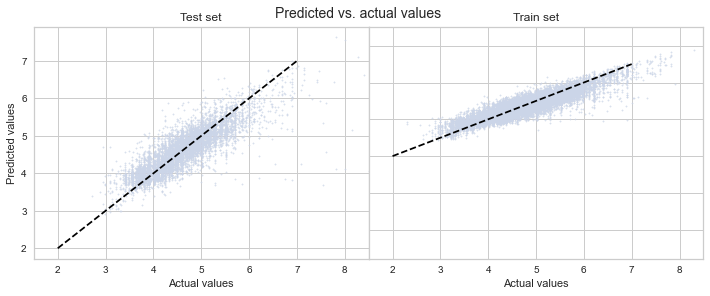

In [106]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_sentiment, y_train_sentiment)
training_preds_xgb_reg = xgb_reg.predict(X_train_sentiment)
val_preds_xgb_reg = xgb_reg.predict(X_test_sentiment)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train_sentiment, training_preds_xgb_reg),4))
print("Test MSE:", round(mean_squared_error(y_test_sentiment, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train_sentiment, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test_sentiment, val_preds_xgb_reg),4))

# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

ax1.scatter(y_test_sentiment, val_preds_xgb_reg, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
ax1.set_xlim((1.5,8.5))

ax2.scatter(y_train_sentiment, training_preds_xgb_reg, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
ax2.set_xlim((1.5,8.5))

plt.show()

### Result
- After incorporating review sentiment scores as additional features, r-square has been much improved from 0.6735 to 0.7103.

Time taken to run: 0.2 minutes

Training MSE: 0.088
Test MSE: 0.1456

Training r2: 0.8139
Test r2: 0.6933

Training adjusted r2: 0.8112
Test adjusted r2: 0.6747


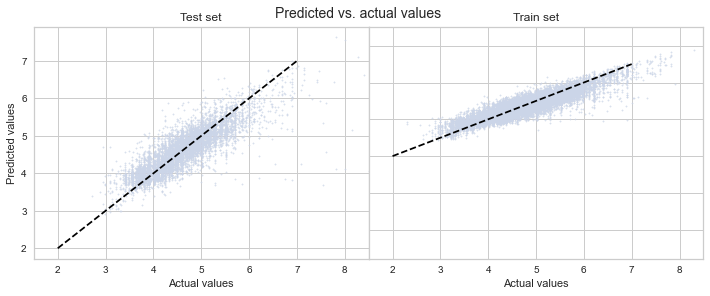

In [107]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_sentiment, y_train_sentiment)
training_preds_xgb_reg = xgb_reg.predict(X_train_sentiment)
val_preds_xgb_reg = xgb_reg.predict(X_test_sentiment)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train_sentiment, training_preds_xgb_reg),4))
print("Test MSE:", round(mean_squared_error(y_test_sentiment, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train_sentiment, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test_sentiment, val_preds_xgb_reg),4))
print("\nTraining adjusted r2:", round(1-(1-r2_score(y_train_sentiment, training_preds_xgb_reg))*((int(X_train_sentiment.shape[0])-1)/(int(X_train_sentiment.shape[0])-int(X_train_sentiment.shape[1])-1)),4))
print("Test adjusted r2:", round(1-(1-r2_score(y_test_sentiment, val_preds_xgb_reg))*((int(X_test_sentiment.shape[0])-1)/(int(X_test_sentiment.shape[0])-int(X_test_sentiment.shape[1])-1)),4))

# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

ax1.scatter(y_test_sentiment, val_preds_xgb_reg, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
ax1.set_xlim((1.5,8.5))

ax2.scatter(y_train_sentiment, training_preds_xgb_reg, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
ax2.set_xlim((1.5,8.5))

plt.show()

In [121]:
# feature importance
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_test_sentiment.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)

pd.set_option('display.max_rows', ft_weights_xgb_reg.shape[0]+1)
ft_weights_xgb_reg

weight
room_type_Entire home/apt                         0.454132
bathrooms_text_1 bath                             0.057171
topic_topic0                                      0.036451
neighbourhood_group_cleansed_Manhattan            0.030370
bathrooms_text_1 private bath                     0.014067
property_type_Room in hotel                       0.013404
neighbourhood_cleansed_Washington Heights         0.008661
neighbourhood_group_cleansed_Brooklyn             0.007697
neighbourhood_cleansed_Midtown                    0.007531
neighbourhood_cleansed_Harlem                     0.007215
gym                                               0.006693
property_type_Private room in apartment           0.006634
accommodates                                      0.006280
bathrooms_text_1 shared bath                      0.006159
neighbourhood_cleansed_Williamsburg               0.005757
host_response_time_a few days or more             0.005455
property_type_Entire loft                         0.005401
topic_topic3                                      0.005239
topic_topic4                                      0.005149
review_scores_location_10/10                      0.005115
tv                                                0.004954
time_since_last_review_2-8 weeks                  0.004761
bathrooms_text_1.5 baths                          0.004645
neighbourhood_cleansed_East Harlem                0.004324
host_response_time_unknown                        0.004094
bedrooms_2 bedrooms                               0.003920
bedrooms_studio                                   0.003870
neighbourhood_cleansed_Inwood                     0.003766
neighbourhood_cleansed_Long Island City           0.003723
neighbourhood_cleansed_Bushwick                   0.003668
time_since_last_review_1+ year                    0.003608
bedrooms_1 bedroom                                0.003367
elevator                                          0.003285
neighbourhood_cleansed_West Village               0.003219
room_type_Hotel room                              0.003135
room_type_Shared room                             0.003098
neighbourhood_cleansed_Greenpoint                 0.003090
host_acceptance_rate_unknown                      0.003054
bathrooms_text_2 baths                            0.003017
neighbourhood_cleansed_SoHo                       0.002942
neighbourhood_cleansed_Bedford-Stuyvesant         0.002910
review_scores_location_9/10                       0.002853
neighbourhood_cleansed_Financial District         0.002721
bedrooms_3 bedrooms                               0.002720
time_since_last_review_6-12 months                0.002655
time_since_last_review_0-2 weeks                  0.002649
availability_90                                   0.002624
neighbourhood_cleansed_Fort Greene                0.002614
property_type_Entire apartment                    0.002600
neighbourhood_cleansed_Cypress Hills              0.002597
neighbourhood_cleansed_Greenwich Village          0.002526
neighbourhood_cleansed_Hell's Kitchen             0.002487
neighbourhood_cleansed_Astoria                    0.002477
bathrooms_text_3.5 baths                          0.002391
room_type_Private room                            0.002383
review_scores_value_10/10                         0.002381
instant_bookable                                  0.002283
neighbourhood_cleansed_Chinatown                  0.002242
neighbourhood_cleansed_Lower East Side            0.002242
neighbourhood_group_cleansed_Bronx                0.002216
review_scores_rating_95-100/100                   0.002203
neighbourhood_cleansed_Clinton Hill               0.002130
neighbourhood_cleansed_Morningside Heights        0.002108
neighbourhood_cleansed_Brighton Beach             0.002032
outdoor_space                                     0.002006
host_days_active                                  0.001985
host_response_rate_0-49%                          0.001978
neighbourhood_cleansed_Chelsea          

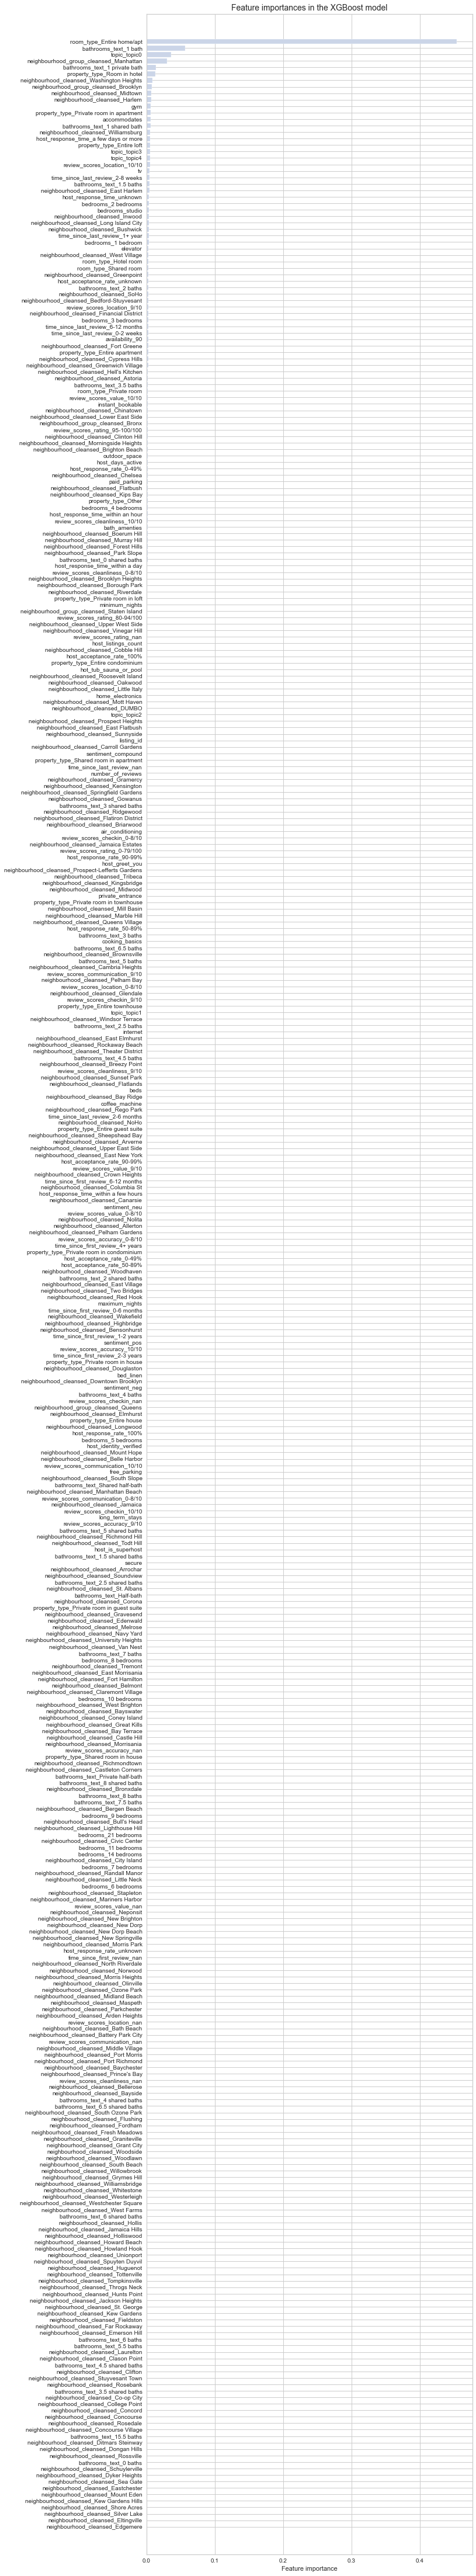

In [123]:
# Plotting feature importances
plt.figure(figsize=(10,80))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.gca().invert_yaxis()
plt.show()